<a href="https://colab.research.google.com/github/argynur/mulaidisini/blob/master/Final_argy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # Untuk menyimpan model

# Unggah file adult.data
# files.upload() # Jika Anda ingin mengunggah secara interaktif

# Unggah file adult.test
# files.upload() # Jika Anda ingin mengunggah secara interaktif

# Setelah diunggah, baca file
# Kolom-kolom untuk dataset Adult (berdasarkan dokumentasi UCI)
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Membaca dataset training
try:
    df_train = pd.read_csv('/content/adult.csv', header=None, names=columns, skipinitialspace=True)
    print("adult.data berhasil dibaca.")
except FileNotFoundError:
    print("Error: adult.data tidak ditemukan. Pastikan file sudah diunggah.")
    exit()

# Membaca dataset testing
# Perhatikan bahwa adult.test memiliki baris pertama yang berbeda dan mungkin tidak memiliki header
# Baris pertama adult.test seringkali adalah "|1xbbbbb" yang perlu diabaikan
try:
    df_test = pd.read_csv('/content/adult.test.csv', header=None, names=columns, skiprows=1, skipinitialspace=True)
    print("adult.test berhasil dibaca.")
except FileNotFoundError:
    print("Error: adult.test tidak ditemukan. Pastikan file sudah diunggah.")
    exit()

# Remove the header row that was read as data
df_train = df_train.iloc[1:].copy()

# Menampilkan informasi awal
print("\n--- Info df_train ---")
df_train.info()
print("\n--- Head df_train ---")
print(df_train.head())

print("\n--- Info df_test ---")
df_test.info()
print("\n--- Head df_test ---")
print(df_test.head())

adult.data berhasil dibaca.
adult.test berhasil dibaca.

--- Info df_train ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 1 to 32561
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  object
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  object
 3   education       32561 non-null  object
 4   education-num   32561 non-null  object
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  object
 11  capital-loss    32561 non-null  object
 12  hours-per-week  32561 non-null  object
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: object(15)
memory usage: 3.7+ MB

--- Head df_train ---


In [2]:
!pip install streamlit scikit-learn pandas matplotlib seaborn joblib

In [3]:
# Menggabungkan data untuk EDA yang konsisten (sementara)
df_combined = pd.concat([df_train, df_test], ignore_index=True)
print("\n--- Info df_combined (untuk EDA) ---")
df_combined.info()
print("\n--- Value Counts for 'income' (Original) ---")
print(df_combined['income'].value_counts())


--- Info df_combined (untuk EDA) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48841 entries, 0 to 48840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48841 non-null  object
 1   workclass       48841 non-null  object
 2   fnlwgt          48841 non-null  object
 3   education       48841 non-null  object
 4   education-num   48841 non-null  object
 5   marital-status  48841 non-null  object
 6   occupation      48841 non-null  object
 7   relationship    48841 non-null  object
 8   race            48841 non-null  object
 9   sex             48841 non-null  object
 10  capital-gain    48841 non-null  object
 11  capital-loss    48841 non-null  object
 12  hours-per-week  48841 non-null  object
 13  native-country  48841 non-null  object
 14  income          48841 non-null  object
dtypes: object(15)
memory usage: 5.6+ MB

--- Value Counts for 'income' (Original) ---
income
<=50K     2

In [4]:
# Ganti '?' dengan NaN
df_train = df_train.replace('?', np.nan)
df_test = df_test.replace('?', np.nan)

# Hapus baris dengan nilai NaN (atau gunakan strategi imputasi yang lebih canggih)
# This should remove rows with NaNs in any column, including categorical ones
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Convert relevant columns to numeric type after dropping NaNs
for col in ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']:
    df_train[col] = pd.to_numeric(df_train[col])
    df_test[col] = pd.to_numeric(df_test[col])

# Convert categorical columns to string type and explicitly handle 'nan' strings
categorical_cols_to_clean = df_train.select_dtypes(include='object').columns.tolist()
# Exclude 'income' as it's the target variable and handled separately
if 'income' in categorical_cols_to_clean:
    categorical_cols_to_clean.remove('income')

for col in categorical_cols_to_clean:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)
    # Replace string representation of NaN with an empty string
    df_train[col] = df_train[col].replace('nan', '')
    df_test[col] = df_test[col].replace('nan', '')


# Normalisasi kolom 'income' (menghapus titik pada df_test jika ada)
df_train['income'] = df_train['income'].str.replace('.', '', regex=False)
df_test['income'] = df_test['income'].str.replace('.', '', regex=False)

print("\n--- Value Counts for 'income' (After Cleaning) ---")
print(df_train['income'].value_counts())
print(df_test['income'].value_counts())

print("\n--- Info df_train (After Type Conversion) ---")
df_train.info()
print("\n--- Info df_test (After Type Conversion) ---")
df_test.info()


--- Value Counts for 'income' (After Cleaning) ---
income
<=50K    22654
>50K      7508
Name: count, dtype: int64
income
<=50K    11359
>50K      3700
Name: count, dtype: int64

--- Info df_train (After Type Conversion) ---
<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32561
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native

In [5]:
print("\n--- Statistik Deskriptif df_train (Numerik) ---")
print(df_train.describe())

print("\n--- Statistik Deskriptif df_train (Kategorikal) ---")
for column in df_train.select_dtypes(include='object').columns:
    print(f"\nKolom: {column}")
    print(df_train[column].value_counts())
    print(f"Jumlah unik: {df_train[column].nunique()}")


--- Statistik Deskriptif df_train (Numerik) ---
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  30162.000000  3.016200e+04   30162.000000  30162.000000  30162.000000   
mean      38.437902  1.897938e+05      10.121312   1092.007858     88.372489   
std       13.134665  1.056530e+05       2.549995   7406.346497    404.298370   
min       17.000000  1.376900e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.176272e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.784250e+05      10.000000      0.000000      0.000000   
75%       47.000000  2.376285e+05      13.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    30162.000000  
mean        40.931238  
std         11.979984  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

--- Statistik

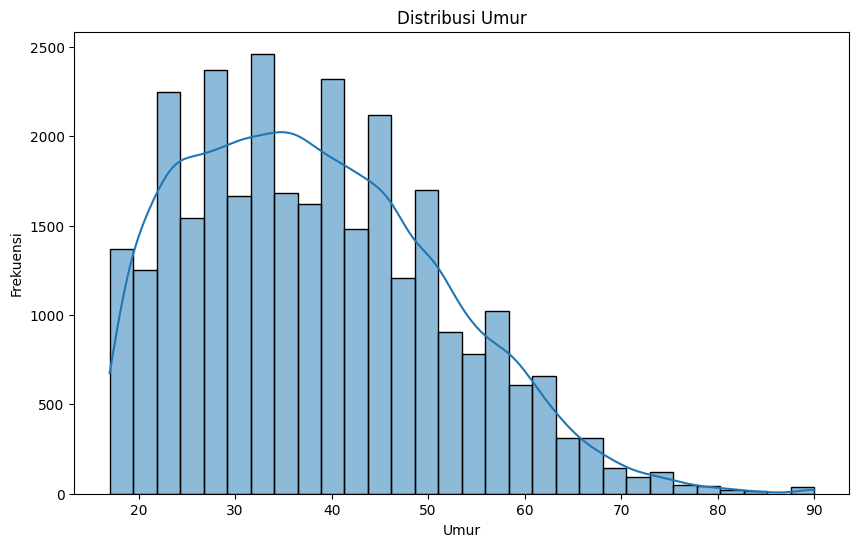

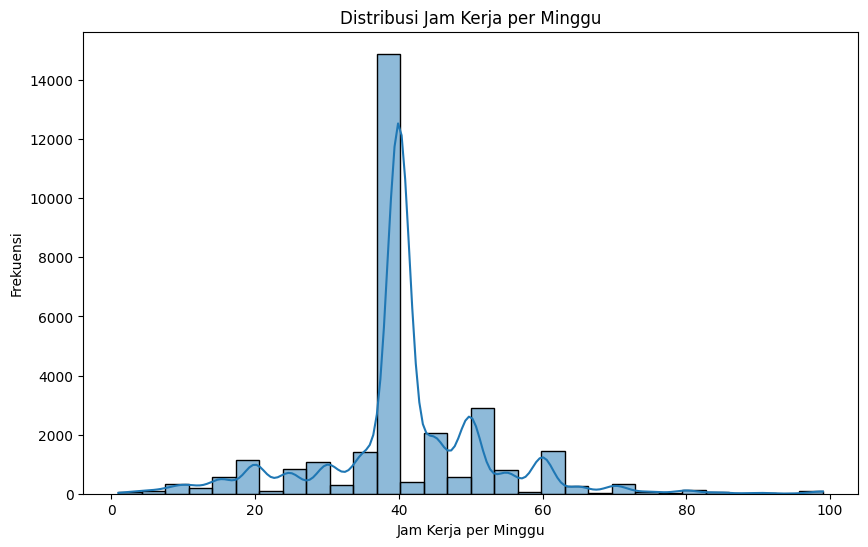

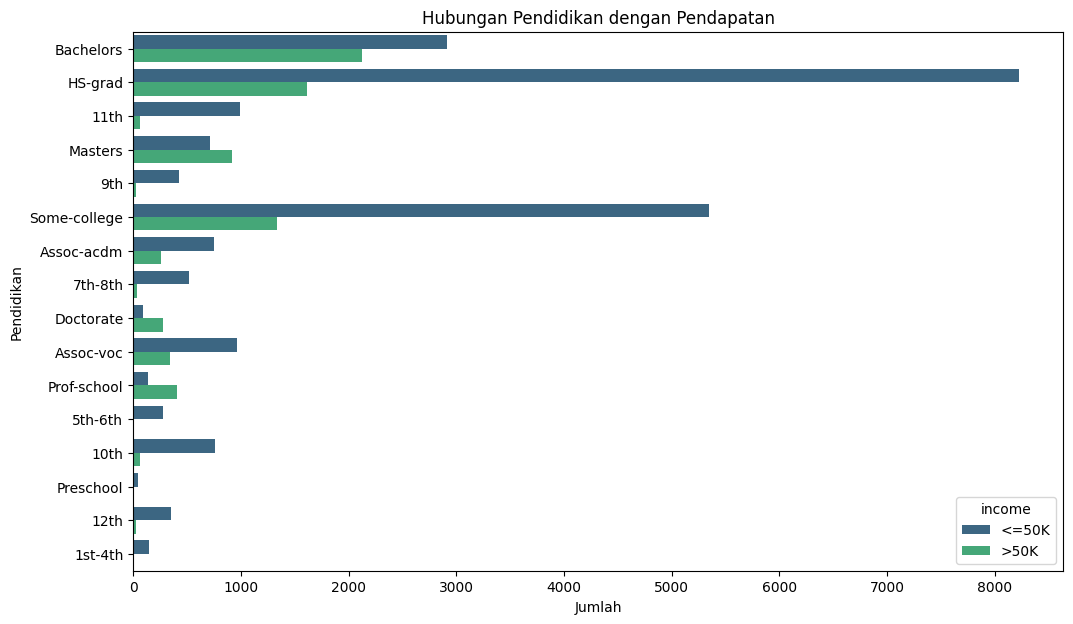

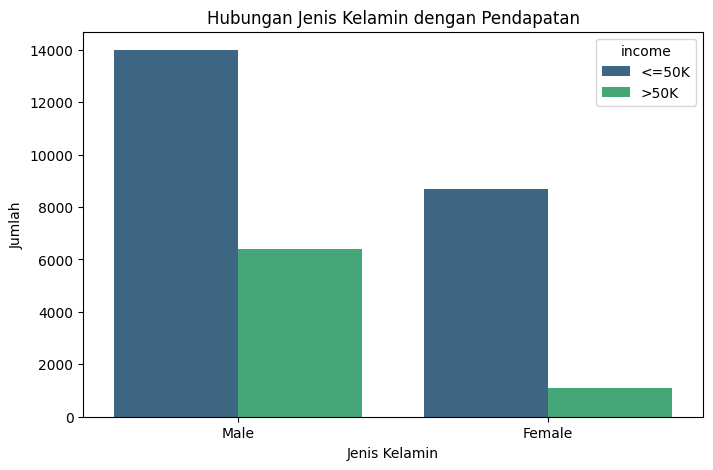

In [6]:
# Distribusi 'age'
plt.figure(figsize=(10, 6))
sns.histplot(df_train['age'], bins=30, kde=True)
plt.title('Distribusi Umur')
plt.xlabel('Umur')
plt.ylabel('Frekuensi')
plt.show()

# Distribusi 'hours-per-week'
plt.figure(figsize=(10, 6))
sns.histplot(df_train['hours-per-week'], bins=30, kde=True)
plt.title('Distribusi Jam Kerja per Minggu')
plt.xlabel('Jam Kerja per Minggu')
plt.ylabel('Frekuensi')
plt.show()

# Hubungan antara 'education' dan 'income'
plt.figure(figsize=(12, 7))
sns.countplot(y='education', hue='income', data=df_train, palette='viridis')
plt.title('Hubungan Pendidikan dengan Pendapatan')
plt.xlabel('Jumlah')
plt.ylabel('Pendidikan')
plt.show()

# Hubungan antara 'sex' dan 'income'
plt.figure(figsize=(8, 5))
sns.countplot(x='sex', hue='income', data=df_train, palette='viridis')
plt.title('Hubungan Jenis Kelamin dengan Pendapatan')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah')
plt.show()

# Korelasi antar variabel numerik (jika ada banyak)
# Untuk dataset ini, hanya ada beberapa kolom numerik
# sns.pairplot(df_train[['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']], hue='income')
# plt.show()

In [7]:
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']

# Encode target variable (misalnya, menjadi 0 dan 1)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test) # Gunakan transform, bukan fit_transform untuk test set

print(f"Mapping target variable: {list(le.classes_)} -> {list(range(len(le.classes_)))}")

Mapping target variable: ['<=50K', '>50K'] -> [0, 1]


In [8]:
# Identifikasi kolom numerik dan kategorikal
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Buat pipeline pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [9]:
# Buat pipeline lengkap dengan pre-processing dan model
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

# Latih model
print("\n--- Melatih model... ---")
model_pipeline.fit(X_train, y_train_encoded)
print("Model berhasil dilatih.")


--- Melatih model... ---
Model berhasil dilatih.



--- Evaluasi Model (Training Set) ---
Akurasi Training: 0.8495

Classification Report (Training):
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     22654
        >50K       0.74      0.61      0.67      7508

    accuracy                           0.85     30162
   macro avg       0.81      0.77      0.79     30162
weighted avg       0.84      0.85      0.84     30162


Confusion Matrix (Training):
[[21048  1606]
 [ 2932  4576]]

--- Inspecting X_test before prediction ---
X_test info:
<class 'pandas.core.frame.DataFrame'>
Index: 15059 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15059 non-null  int64 
 1   workclass       15059 non-null  object
 2   fnlwgt          15059 non-null  int64 
 3   education       15059 non-null  object
 4   education-num   15059 non-null  int64 
 5   marital-status  15059 non-null  object

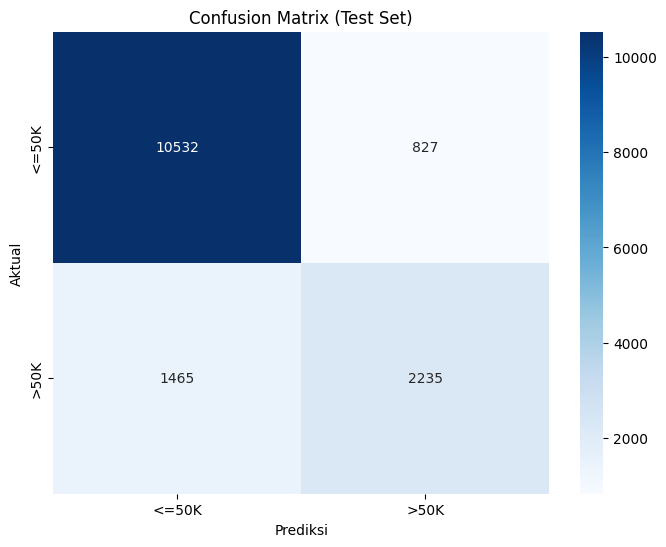

In [10]:
# Prediksi pada training set
y_train_pred = model_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print(f"\n--- Evaluasi Model (Training Set) ---")
print(f"Akurasi Training: {train_accuracy:.4f}")
print("\nClassification Report (Training):")
print(classification_report(y_train_encoded, y_train_pred, target_names=le.classes_))
print("\nConfusion Matrix (Training):")
print(confusion_matrix(y_train_encoded, y_train_pred))

# Add inspection of X_test before prediction
print("\n--- Inspecting X_test before prediction ---")
print("X_test info:")
X_test.info()
print("\nUnique values and dtypes for categorical columns in X_test:")
categorical_cols_test = X_test.select_dtypes(include='object').columns
for col in categorical_cols_test:
    print(f"\nColumn: {col}")
    print(f"Dtype: {X_test[col].dtype}")
    print("Unique values:")
    # Print only a few unique values if there are many
    unique_vals = X_test[col].unique()
    if len(unique_vals) > 20:
        print(unique_vals[:20])
        print(f"... and {len(unique_vals) - 20} more unique values")
    else:
        print(unique_vals)

    # Add check for non-string types
    non_string_types = X_test[col].apply(lambda x: type(x) != str).sum()
    if non_string_types > 0:
        print(f"WARNING: Found {non_string_types} non-string entries in column '{col}'")
        # Optionally print the types of these entries
        # print(X_test[col][X_test[col].apply(lambda x: type(x) != str)].apply(type).unique())


# Prediksi pada test set
y_test_pred = model_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"\n--- Evaluasi Model (Test Set) ---")
print(f"Akurasi Test: {test_accuracy:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test_encoded, y_test_pred, target_names=le.classes_))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test_encoded, y_test_pred))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_encoded, y_test_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [11]:
# Simpan model dan LabelEncoder
joblib.dump(model_pipeline, 'adult_income_predictor.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("\nModel dan LabelEncoder berhasil disimpan.")


Model dan LabelEncoder berhasil disimpan.


In [12]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# Muat model dan LabelEncoder
try:
    model = joblib.load('adult_income_predictor.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
except FileNotFoundError:
    st.error("Model atau LabelEncoder tidak ditemukan. Pastikan 'adult_income_predictor.pkl' dan 'label_encoder.pkl' ada di direktori yang sama.")
    st.stop() # Hentikan eksekusi Streamlit jika file tidak ditemukan

st.title('Prediksi Pendapatan Individu')
st.write('Aplikasi ini memprediksi apakah pendapatan seseorang lebih dari $50K atau kurang dari/sama dengan $50K berdasarkan karakteristiknya.')

st.sidebar.header('Input Fitur')

# Fungsi untuk mendapatkan input dari pengguna
def user_input_features():
    age = st.sidebar.slider('Umur', 17, 90, 30)
    workclass = st.sidebar.selectbox('Kelas Pekerja', [
        'Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov',
        'State-gov', 'Without-pay', 'Never-worked'
    ])
    fnlwgt = st.sidebar.slider('Final Weight (fnlwgt)', 10000, 1500000, 150000)
    education = st.sidebar.selectbox('Pendidikan', [
        'Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school',
        'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters',
        '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'
    ])
    education_num = st.sidebar.slider('Tingkat Pendidikan (Numerik)', 1, 16, 10)
    marital_status = st.sidebar.selectbox('Status Perkawinan', [
        'Married-civ-spouse', 'Divorced', 'Never-married', 'Separated',
        'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'
    ])
    occupation = st.sidebar.selectbox('Pekerjaan', [
        'Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial',
        'Prof-specialty', 'Handlers-cleaners', 'Adm-clerical', 'Farming-fishing',
        'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'
    ])
    relationship = st.sidebar.selectbox('Hubungan', [
        'Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'
    ])
    race = st.sidebar.selectbox('Ras', [
        'White', 'Asian-Pac-Islander', 'Black', 'Amer-Indian-Eskimo', 'Other'
    ])
    sex = st.sidebar.selectbox('Jenis Kelamin', ['Male', 'Female'])
    capital_gain = st.sidebar.slider('Capital Gain', 0, 100000, 0)
    capital_loss = st.sidebar.slider('Capital Loss', 0, 5000, 0)
    hours_per_week = st.sidebar.slider('Jam Kerja per Minggu', 1, 99, 40)
    native_country = st.sidebar.selectbox('Negara Asal', [
        'United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Germany',
        'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South',
        'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland',
        'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France',
        'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia',
        'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand',
        'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong',
        'Holand-Netherlands'
    ])

    data = {
        'age': age,
        'workclass': workclass,
        'fnlwgt': fnlwgt,
        'education': education,
        'education-num': education_num,
        'marital-status': marital_status,
        'occupation': occupation,
        'relationship': relationship,
        'race': race,
        'sex': sex,
        'capital-gain': capital_gain,
        'capital-loss': capital_loss,
        'hours-per-week': hours_per_week,
        'native-country': native_country
    }
    features = pd.DataFrame(data, index=[0])
    return features

df_input = user_input_features()

st.subheader('Input Pengguna')
st.write(df_input)

if st.button('Prediksi'):
    try:
        # Lakukan prediksi
        prediction_encoded = model.predict(df_input)
        prediction_proba = model.predict_proba(df_input)

        # Decode hasil prediksi
        prediction_class = label_encoder.inverse_transform(prediction_encoded)[0]

        st.subheader('Hasil Prediksi')
        st.write(f'Pendapatan Diprediksi: **{prediction_class}**')

        st.subheader('Probabilitas Prediksi')
        proba_df = pd.DataFrame(prediction_proba, columns=label_encoder.classes_)
        st.write(proba_df)

    except Exception as e:
        st.error(f"Terjadi kesalahan saat memprediksi: {e}")
        st.write("Pastikan semua fitur input memiliki format yang benar sesuai dengan model yang dilatih.")

st.markdown("""
---
*Catatan: Aplikasi ini menggunakan model machine learning yang dilatih pada dataset sensus penduduk.*
""")

Overwriting app.py


In [13]:
# Instal ngrok (jika belum terinstal di sesi Colab ini)
!pip install pyngrok

# Jalankan Streamlit di background
print("Menjalankan aplikasi Streamlit di background...")
!nohup streamlit run app.py &

# Dapatkan URL ngrok untuk mengakses aplikasi Streamlit
import time
from pyngrok import ngrok

print("Menghentikan koneksi ngrok sebelumnya (jika ada)...")
ngrok.kill()

# Tambahkan penundaan untuk memberi waktu Streamlit memulai
print("Memberikan waktu 10 detik agar Streamlit memulai sepenuhnya...")
time.sleep(10) # <-- Pastikan ada penundaan ini

print("Mencoba membuat tunnel ngrok baru...")
try:
    public_url = ngrok.connect(8501)
    print(f"\n--- Streamlit App URL: {public_url} ---")
    print("Salin URL di atas dan tempelkan di browser Anda untuk melihat aplikasi.")
except Exception as e:
    print(f"Gagal membuat tunnel ngrok: {e}")
    print("Coba periksa log Streamlit di nohup.out untuk petunjuk lebih lanjut.")

Menjalankan aplikasi Streamlit di background...
nohup: appending output to 'nohup.out'
Menghentikan koneksi ngrok sebelumnya (jika ada)...
Memberikan waktu 10 detik agar Streamlit memulai sepenuhnya...
Mencoba membuat tunnel ngrok baru...


ERROR:pyngrok.process.ngrok:t=2025-07-22T13:01:33+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-22T13:01:33+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


Gagal membuat tunnel ngrok: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.
Coba periksa log Streamlit di nohup.out untuk petunjuk lebih lanjut.
